# Introduction

- Unsupervised learning
- Similar datapoints end up in the same cluster
- Finds natural groups in the feature space

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [2]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=21)

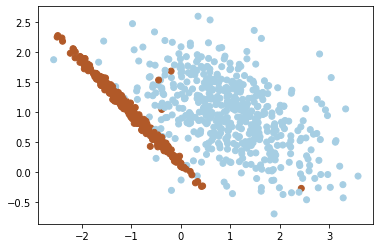

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

## 1) Affinity Propagation

### How it works:

Consider this dataset:
<img src="dataset.png">

#### a) Calculate Similarity Matrix

For this, take the sum of squared differences between each feature of two people, and change its sign. Example: For Alice and Bob:

<br>
$SimilarityMatrix(Alice, Bob) = -((3-4)^2 + (4-3)^2 + (3-5)^2 + (2-1)^2 + (1-1)^2)$<br>
$SimilarityMatrix(Alice, Bob) = -(7)$


Do this for every other pair, you'll end up with this:

<img src="similarity matrix 1.png">

Replace zeros with the minimum element of the matrix, in this case, -22:

<img src="similarity matrix 2.png">

#### b) Responsibility Matrix

For this, use this formula, if S represents Similarity Matrix and R represents Responsibility Matrix, then for Bob(column) to Alice(row) is $SimilarityMatrix(Alice, Bob)$ minus the maximum Similarity element in Alice's row, i.e. -6:

$R[Alice, Bob] = S[Alice, Bob] - (-6)$<br>
$R[Alice, Bob] = -7 + 6$<br>
$R[Alice, Bob] = -1$<br>

Do this for every other pair.

<img src="responsibility matrix.png">

#### c) Availability Matrix

In this steps, we'll use two different formulas for updating the diagonal and non-diagnoal elements of the Availability Matrix

1. Diagonal Elements ((Alice, Alice), (Bob, Bob), etc.)

For these, simply add up the non-negative elements in the person's column. In case of Alice, it will be:

$AvailabilityMatrix(Alice, Alice) = 0 + 10 + 11 + 0 + 0$
$AvailabilityMatrix(Alice, Alice) = 21$

Calculate the same for all other people

These elements are called **Self-Responsibilities**

2. Non-Diagonal Elements ((Alice, Bob), (Alice, Edna), etc)

For these, if we're talking about Alice(row) and Bob(column), the calculation is Bob's Self-Responsibility plus the sum of all non-negative entries in Bob's column, i.e.:

$AvailabilityMatrix(Alice, Bob) = SelfResponsibility(Bob) + 0$

as there aren't any non-negative elements in Bob's column, so

$AvailabilityMatrix(Alice, Bob) = ResponsibilityMatrix(Bob, Bob)$
$AvailabilityMatrix(Alice, Bob) = -15$

Again, do this for all the other pairs, we'll end up with:

<img src="availability matrix.png">

#### d) Criterion Matrix

Simply add elements in Responsibility Matrix and Availability Matrix to end up with:

<img src="criterion matrix.png">

**IMPORTANT NOTE:** Features must be normalized before using Affinity Propagation 

In [4]:
from sklearn.cluster import AffinityPropagation

Total 26 classes:


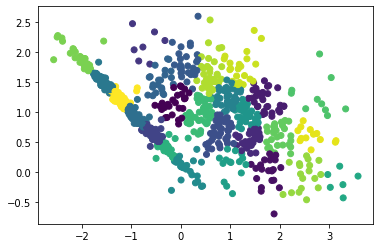

In [5]:
model = AffinityPropagation(damping=0.9)
model.fit(X, y)
preds = model.predict(X)

print(f'Total {np.unique(preds).shape[0]} classes:')

plt.scatter(X[:, 0], X[:, 1], c=preds);

## 2) Agglomerative Clustering

- Part of hierarchical clustering

Goes like this:

- Consider each datapoint as a cluster
- Merge the two closest clusters
- Keep merging until there's only one cluster remaining

In [6]:
from sklearn.cluster import AgglomerativeClustering

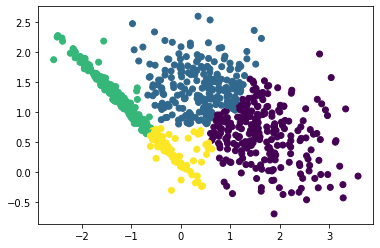

In [7]:
model = AgglomerativeClustering(n_clusters=4)
preds = model.fit_predict(X, y)

plt.scatter(X[:, 0], X[:, 1], c=preds);

## 3) BIRCH (Balanced Iterative Reducing and Clustering Using Hierarchies)

BIRCH algorithm uses a tree structure to create a cluster. It is also called the Clustering Feature Tree or CF Tree. Each node of this tree contains several Clustering Features (CFs) 

Each node including leaf nodes has several CFs, and the CFs of internal nodes have pointers to child nodes, and all leaf nodes are linked by a doubly linked list.

<img src="CF tree.png">

Every Clustering Feature  can be represented by three things:

- N: the number of sample points in the CF
- LS: vector sum of sample points' features
- SS: squared vector sum of sample points' features

For example:

<img src="CF definition.png">

where

<img src="sum and squared sum.png">

CFs can also be added/subtracted, i.e. it satisfies linear relationship:

<img src="CF linear relationship.png">

So if we define a CF tree, we can say that the parameters(N, LS, SS) of parent CF are the sum of all its children:

<img src="CF tree sum.jpeg">

### CF Tree Generation:

1. CF Tree is empty now
2. Read the first sample point, say point A

<img src="point a.jpeg">

3. Read second point, if it is within the range of a hyperspher with a radius T. If it is, form a cluster A

<img src="point b.jpeg">

4. Read the third point, we find that it cannot be inserted into cluster A as it doesn't fall inside the hyper-sphere formed by cluster A

<img src="cluster b.jpeg">

5. Read the fourth point, it falls inside cluster B.

<img src="fourth point.jpeg">

But when does the node of the CF tree need to be split?

Suppose our current CF Tree is shown in the following figure:

<img src="CF tree 2.jpeg">

The leaf node LN1 has 3 CFs, while LN2 and LN3 have 2 CFs each.

Now if we read a new point and find that it is closest to LN1, we'd need to insert it in LN1 using name **sc8**:

<img src="sc8.jpeg">

But doing this exceeds the maximum possible leaf node value(L = 3), i.e. LN1 now has four children and that is not acceptible. So, we split LN1 into two nodes, LN1' and LN2'':

<img src="sibling LN1.jpeg">

Now again we need to look at the internal nodes, if B = 3(maximum number of internal nodes allowed), then the above is not accepted and the root is split. In our case, there are 4 internal nodes, **LN1', LN1'', LN2 and LN3**. So, the root of these nodes need to be split:

<img src="root split.jpeg">



In [8]:
from sklearn.cluster import Birch

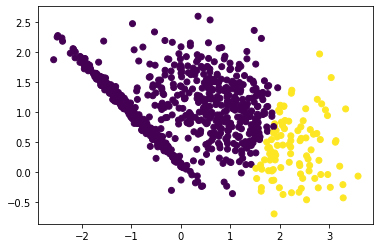

In [10]:
model = Birch(n_clusters=2)
preds = model.fit_predict(X, y)

plt.scatter(X[:, 0], X[:, 1], c=preds);

## 4) DBSCAN (Density Based Spatial Clustering of Applications with Noise)

Other methods always consider clusters to be of spherical shape, but these don't consider the density of the datapoints being modeled. DBSCAN takes care of this:

DBSCAN has two parameters that we need to think of:

1. `eps` - the radius of the cluster to be formed
2. `min_points` - minimum points needed for a sphere to be considered a cluster

DBSCAN works like this:

<img src="dbscan.png">

Suppose we have three continuous features. The datapoints are shown in the above figure. The red points are called "core" points. These points have at least `min_points` points contained in the sphere radius(`eps`) described by them. Yellow points are border points, they are within the `eps` distance but do not satisfy the at least `min_points` rule. Blue points are noise points, they are not assigned to any cluster. In this way, DBSCAN is capable of handling outliers as well and clusters data points on the basis of their density

In [11]:
from sklearn.cluster import DBSCAN

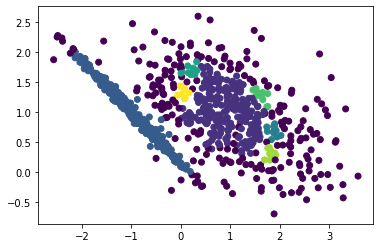

In [37]:
model = DBSCAN(eps=0.15, min_samples=9) # min_samples = min_points
preds = model.fit_predict(X, y)

plt.scatter(X[:, 0], X[:, 1], c=preds);

## 5) K-Means

The most popular technique for clustering. Works like this:

1. Randomly define cluster centers
2. For all the datapoints assign the cluster of the cluster center from which they are the nearest to
3. Update the cluster center using the means of all the datapoints in the given cluster
4. Continue doing 2 and 3 till the cluster don't change much

In [38]:
from sklearn.cluster import KMeans

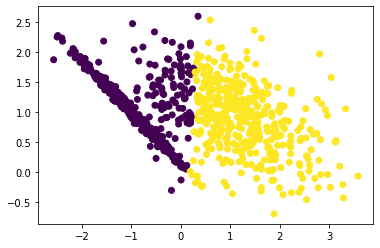

In [39]:
model = KMeans(n_clusters=2)
model.fit(X)

preds = model.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=preds)

# References

- https://machinelearningmastery.com/clustering-algorithms-with-python/
- https://towardsdatascience.com/unsupervised-machine-learning-affinity-propagation-algorithm-explained-d1fef85f22c8
- https://towardsdatascience.com/birch-clustering-clearly-explained-ffd75f07e5ed
- https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818